In [ ]:
!pip install roboflow
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.9 MB/s eta 0:00:00
   ━

In [ ]:
from roboflow import Roboflow

# Inisialisasi Roboflow
rf = Roboflow(api_key="f7zlD4r0HUuGAgpvfk6K")
project = rf.workspace("reva-h29s3").project("helmet-detection-20241116-bshco")
version = project.version(1)

# Download dataset dalam format YOLOv8
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to helmet-detection-20241116-1 in yolov8:: 100%|██████████| 9452/9452 [00:06<00:00, 1552.78it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import yaml
import os

# Baca file data.yaml
with open(os.path.join(dataset.location, "data.yaml")) as f:
    data_yaml = yaml.safe_load(f)

print("Kelas Asli:", data_yaml['names'])

Kelas Asli: ['bicyclist', 'driver', 'helmet', 'no-helmet']


In [ ]:
# Simpan kelas yang ingin digunakan
allowed_classes = ['helmet', 'no-helmet']
old_classes = data_yaml['names']

# Mapping index lama ke baru
allowed_indexes = [old_classes.index(c) for c in allowed_classes]
class_index_map = {old_classes.index(c): i for i, c in enumerate(allowed_classes)}

# Update data.yaml
data_yaml['names'] = allowed_classes
data_yaml['nc'] = len(allowed_classes)

with open(os.path.join(dataset.location, "data.yaml"), "w") as f:
    yaml.dump(data_yaml, f)

print("✅ data.yaml diperbarui.")


✅ data.yaml diperbarui.


In [ ]:
def filter_yolo_labels(split):
    label_path = os.path.join(dataset.location, split, 'labels')
    image_path = os.path.join(dataset.location, split, 'images')

    for fname in os.listdir(label_path):
        label_file = os.path.join(label_path, fname)
        with open(label_file, 'r') as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            cls, rest = line.strip().split(' ', 1)
            cls = int(cls)
            if cls in allowed_indexes:
                new_cls = class_index_map[cls]
                new_lines.append(f"{new_cls} {rest}\n")

        if new_lines:
            with open(label_file, 'w') as f:
                f.writelines(new_lines)
        else:
            os.remove(label_file)
            img_file = os.path.join(image_path, fname.replace('.txt', '.jpg'))
            if os.path.exists(img_file):
                os.remove(img_file)

# Terapkan ke train, valid, test
for split in ['train', 'valid', 'test']:
    filter_yolo_labels(split)

print("✅ Dataset difilter.")


✅ Dataset difilter.


In [ ]:
from ultralytics import YOLO

# Inisialisasi model YOLOv8 nano
model = YOLO('yolov8n.pt')

# Mulai training
model.train(data=os.path.join(dataset.location, "data.yaml"),
            epochs=30,
            imgsz=640,
            batch=16)

100%|██████████| 6.25M/6.25M [00:00<00:00, 108MB/s]


Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/helmet-detection-20241116-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

100%|██████████| 755k/755k [00:00<00:00, 24.7MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    751702  ultralytics.nn.modules.head.Detect           [2, [64, 128, 256]]           
Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 94.8MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2062.3±860.6 MB/s, size: 113.8 KB)


train: Scanning /content/helmet-detection-20241116-1/train/labels... 3717 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3717/3717 [00:01<00:00, 2337.55it/s]


train: New cache created: /content/helmet-detection-20241116-1/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 60, len(boxes) = 15321. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1426.1±1194.1 MB/s, size: 424.9 KB)


val: Scanning /content/helmet-detection-20241116-1/valid/labels... 485 images, 0 backgrounds, 0 corrupt: 100%|██████████| 485/485 [00:00<00:00, 1033.70it/s]


val: New cache created: /content/helmet-detection-20241116-1/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 3689. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.39G      1.334      1.889      1.101         29        640: 100%|██████████| 233/233 [01:22<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


                   all        485       3689      0.717      0.643      0.697      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.79G      1.338      1.253      1.086         38        640: 100%|██████████| 233/233 [01:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


                   all        485       3689      0.784      0.653      0.721      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.8G      1.335      1.122      1.088         16        640: 100%|██████████| 233/233 [01:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


                   all        485       3689      0.778      0.645      0.733      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.81G      1.289      1.021      1.077         38        640: 100%|██████████| 233/233 [01:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]

                   all        485       3689      0.822      0.708      0.781      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.84G       1.27      0.945       1.06         37        640: 100%|██████████| 233/233 [01:18<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


                   all        485       3689      0.816      0.703      0.779      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.85G      1.227     0.8837      1.044         54        640: 100%|██████████| 233/233 [01:19<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all        485       3689      0.854      0.723      0.802      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.87G      1.175     0.8197      1.021         60        640: 100%|██████████| 233/233 [01:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


                   all        485       3689      0.856       0.74      0.811      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.88G      1.167     0.8144      1.022         20        640: 100%|██████████| 233/233 [01:20<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]

                   all        485       3689      0.864      0.745      0.821      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       2.9G      1.148     0.7878      1.013         43        640: 100%|██████████| 233/233 [01:19<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all        485       3689      0.871      0.723      0.819      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.92G      1.108     0.7501      1.006         22        640: 100%|██████████| 233/233 [01:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]

                   all        485       3689      0.857      0.753       0.83       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.94G      1.111     0.7344      1.003         41        640: 100%|██████████| 233/233 [01:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.29it/s]

                   all        485       3689      0.865      0.761      0.837      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.95G      1.089     0.7224     0.9994         47        640: 100%|██████████| 233/233 [01:21<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


                   all        485       3689      0.874      0.752      0.834      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.97G      1.071     0.6929     0.9919         37        640: 100%|██████████| 233/233 [01:20<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]

                   all        485       3689      0.857      0.769      0.843      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.99G      1.064     0.6926     0.9767         45        640: 100%|██████████| 233/233 [01:19<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


                   all        485       3689      0.869      0.761      0.848      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.01G      1.035      0.667     0.9764         61        640: 100%|██████████| 233/233 [01:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.26it/s]

                   all        485       3689      0.889      0.768      0.855      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.01G      1.022     0.6425     0.9723         42        640: 100%|██████████| 233/233 [01:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


                   all        485       3689      0.876      0.774      0.849      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.05G      1.031     0.6394     0.9662         14        640: 100%|██████████| 233/233 [01:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]

                   all        485       3689      0.877      0.771      0.857      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.06G      1.002     0.6301     0.9619         33        640: 100%|██████████| 233/233 [01:21<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]

                   all        485       3689      0.889      0.765      0.864      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.08G     0.9967     0.6161     0.9642         21        640: 100%|██████████| 233/233 [01:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]

                   all        485       3689      0.886      0.784      0.864      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.08G     0.9694      0.595     0.9528         34        640: 100%|██████████| 233/233 [01:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]


                   all        485       3689      0.887      0.796      0.867      0.574
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.11G     0.9373      0.559     0.9412         19        640: 100%|██████████| 233/233 [01:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]

                   all        485       3689      0.881      0.783       0.86      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.13G     0.9317     0.5426     0.9361         26        640: 100%|██████████| 233/233 [01:16<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        485       3689      0.889      0.786      0.869      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.14G     0.9077     0.5301     0.9257         22        640: 100%|██████████| 233/233 [01:14<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]

                   all        485       3689      0.893      0.789      0.871      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.15G     0.9019     0.5194     0.9242         16        640: 100%|██████████| 233/233 [01:18<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


                   all        485       3689      0.892      0.799      0.875      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.18G     0.8786     0.4988     0.9152         18        640: 100%|██████████| 233/233 [01:16<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]

                   all        485       3689      0.887       0.78       0.87      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       3.2G     0.8676     0.4909      0.914          5        640: 100%|██████████| 233/233 [01:17<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


                   all        485       3689      0.891      0.784      0.874      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.21G     0.8559     0.4808     0.9066         17        640: 100%|██████████| 233/233 [01:16<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all        485       3689      0.884      0.799      0.879      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.22G     0.8387     0.4664     0.9014         16        640: 100%|██████████| 233/233 [01:18<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


                   all        485       3689      0.891      0.801      0.882      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.25G     0.8307     0.4558     0.8957         21        640: 100%|██████████| 233/233 [01:15<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]

                   all        485       3689      0.901      0.794       0.88      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.26G      0.823     0.4529     0.8932         15        640: 100%|██████████| 233/233 [01:16<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        485       3689      0.893      0.803      0.883      0.606



30 epochs completed in 0.722 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]


                   all        485       3689      0.894      0.803      0.883      0.606
                helmet        333       2035      0.901      0.818      0.882      0.644
             no-helmet        289       1654      0.886      0.788      0.884      0.568
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f60bd637b90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

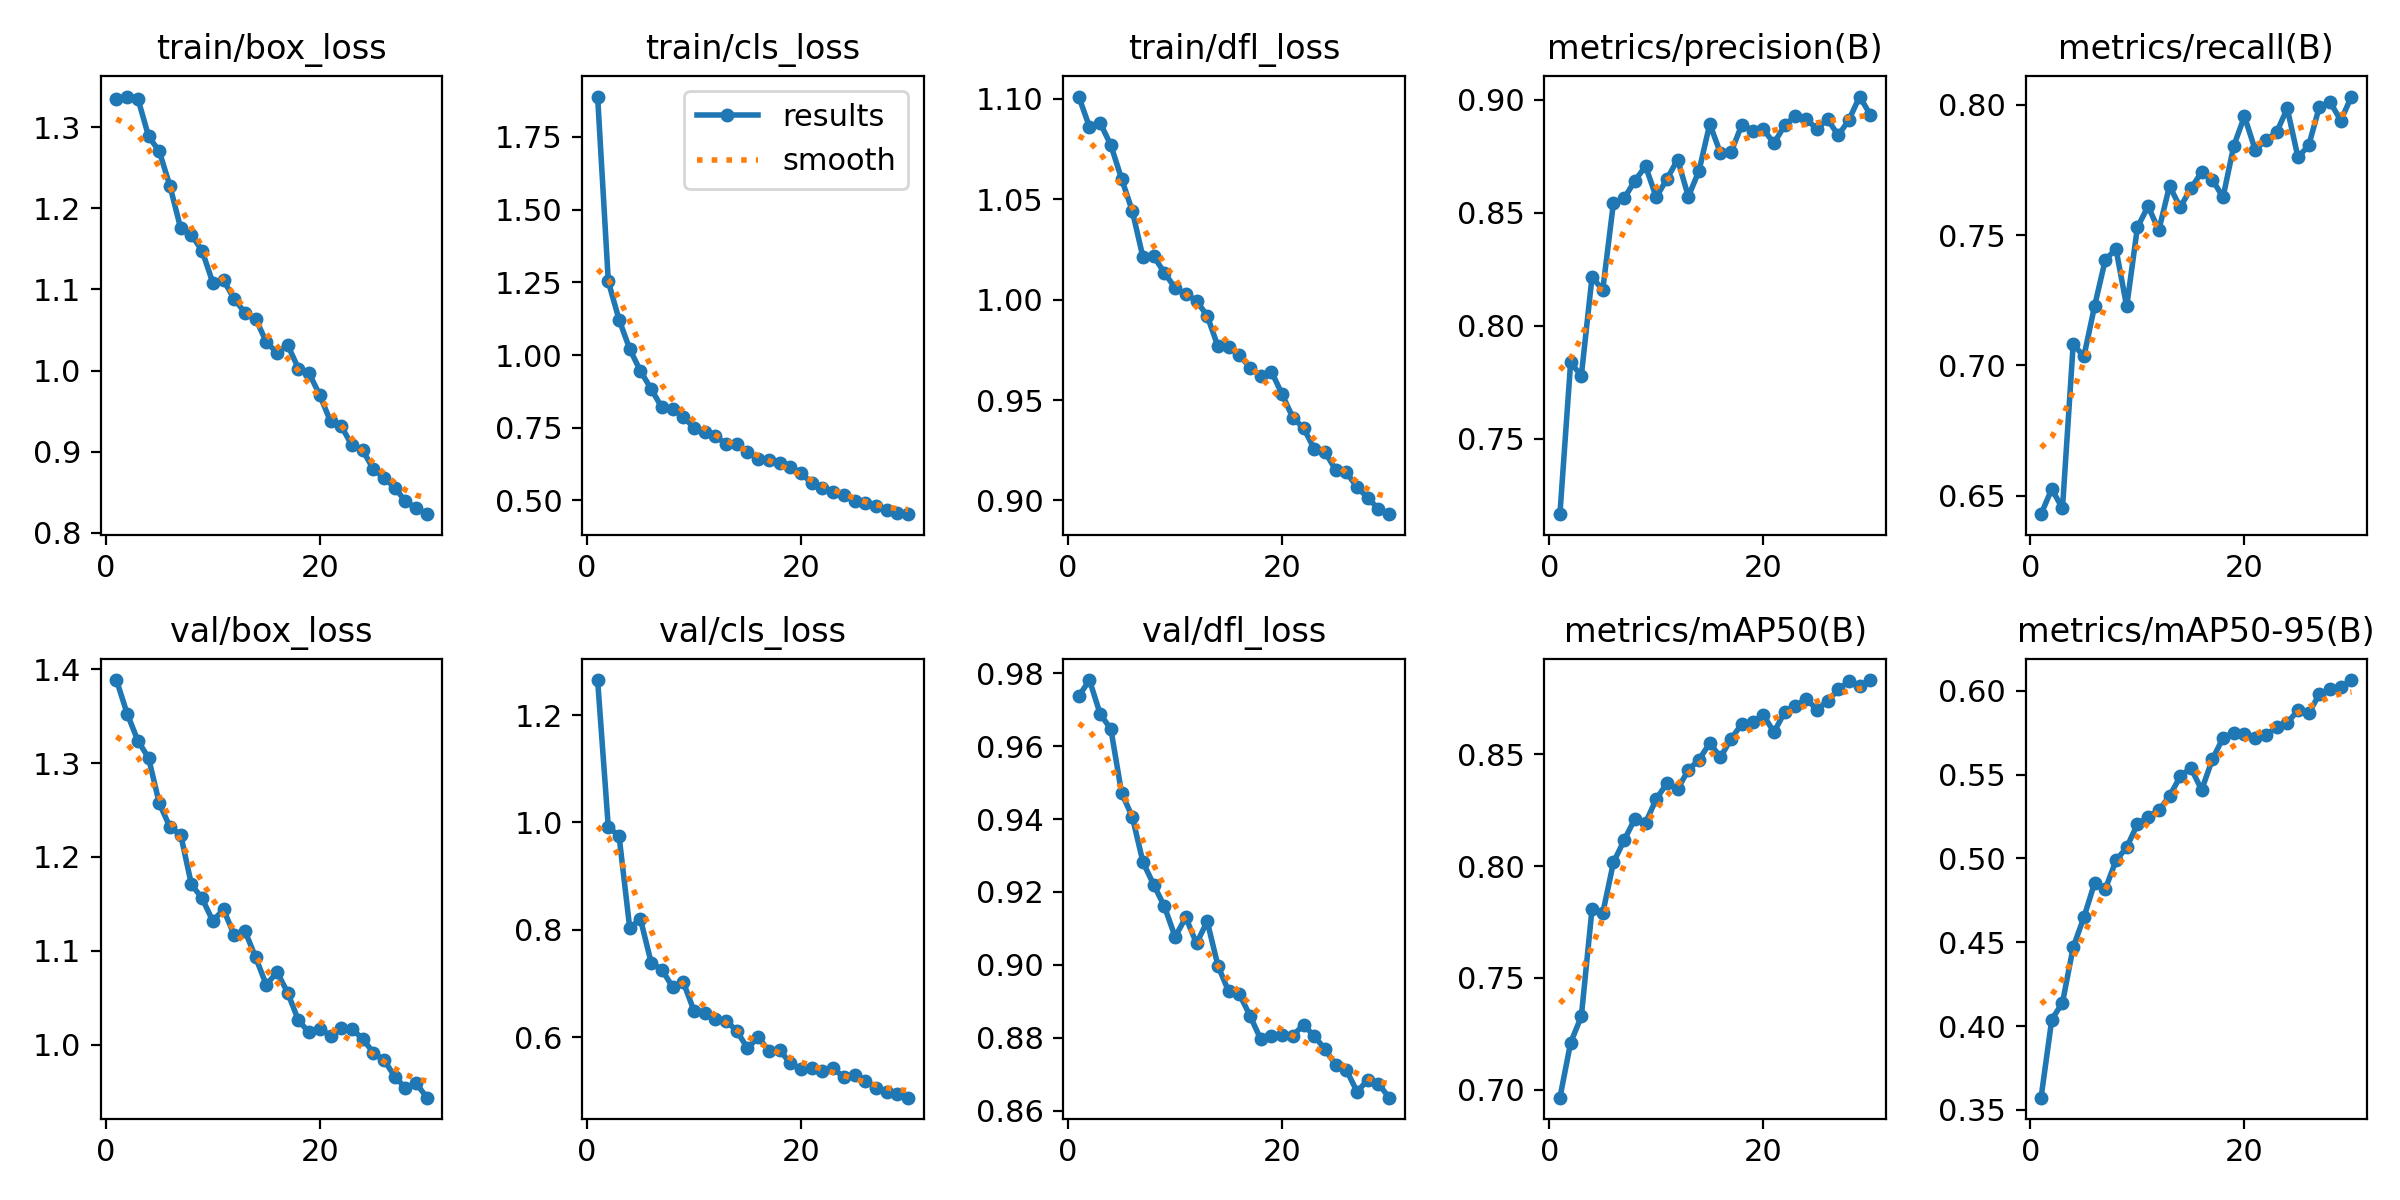

In [ ]:
from IPython.display import Image

# Path ke hasil training YOLOv8
Image(filename='runs/detect/train/results.png', width=700)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving helm.jpeg to helm.jpeg



image 1/1 /content/helm.jpeg: 320x640 2 helmets, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs/detect/predict2


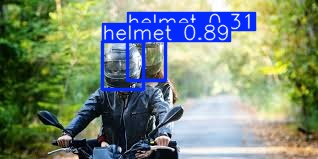

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os

# 1. Load model hasil training
model = YOLO('/content/runs/detect/train/weights/best.pt')

# 2. Lakukan prediksi pada gambar
results = model('/content/helm.jpeg', save=True)

# 3. Ambil path hasil deteksi
save_dir = results[0].save_dir  # direktori output
predicted_image_path = os.path.join(save_dir, 'helm.jpg')

# 4. Tampilkan hasil deteksi
display(Image(filename=predicted_image_path))

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ga helm.jpeg to ga helm.jpeg



image 1/1 /content/ga helm.jpeg: 416x640 2 helmets, 2 no-helmets, 41.0ms
Speed: 2.0ms preprocess, 41.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict3


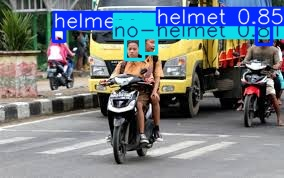

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os

# 1. Load model hasil training
model = YOLO('/content/runs/detect/train/weights/best.pt')

# 2. Lakukan prediksi pada gambar
results = model('/content/ga helm.jpeg', save=True)

# 3. Ambil path hasil deteksi
save_dir = results[0].save_dir  # direktori output
predicted_image_path = os.path.join(save_dir, 'ga helm.jpg')

# 4. Tampilkan hasil deteksi
display(Image(filename=predicted_image_path))

In [ ]:
from google.colab import files
files.download('/content/runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>